In [1]:
#from asgmnt_2_tools import read_pickle_jar
import os 
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    classification_report
)
from sklearn.tree import export_graphviz
from scipy.sparse import issparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import plot_tree
#from pydotplus import graph_from_dot_file
import pickle

In [2]:
# figure saving path
figpath = "./figures/"

# Drive path:
path_google = "../../Data/GoogleDrive/"

In [3]:
# all pickles
pickle_jar = read_pickle_jar(path_google)
# Example Use
pickle_jar["back_selection"]

/opt/anaconda3/envs/203C/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/203C/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


SequentialFeatureSelector(direction='backward',
                          estimator=LogisticRegression(max_iter=300,
                                                       solver='liblinear'),
                          scoring='f1')

### Reading in the predicted test results from all models

In [3]:
indir = '../../Data/GoogleDrive/'

X_train = indir + 'X_train.parquet'
X_test = indir + 'X_test.parquet'
y_train = indir + 'y_train.parquet'
y_test = indir + 'y_test.parquet'
test_predicted = indir + 'fixed_test_predicted.parquet'

X_train = pd.read_parquet(X_train)
X_test = pd.read_parquet(X_test)
y_train = pd.read_parquet(y_train)
y_test = pd.read_parquet(y_test)
test_predicted = pd.read_parquet(test_predicted)

y_pred_test_logi = test_predicted['logi_predicted']
y_pred_prob_logi = test_predicted['logi_predicted_prob']
y_pred_test_knn = test_predicted['knn_predicted']
y_pred_prob_knn = test_predicted['knn_predicted_prob']

# with open(path_google + "back_selection.pkl", "rb") as file:
#     back_selector = pickle.load(file)

# # Get the selected feature names
# selected_features = back_selector.get_feature_names_out()

# # Transform the training and testing data using the selected feature names
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]

# add RF and XGB predictions below

In [4]:
log_final = pickle.load(open(path_google + 'logit_model_fixed.pkl', 'rb'))
log_final = log_final.best_estimator_.named_steps['clf']

knn_final = pickle.load(open(path_google + 'knn_model_fixed.pkl', 'rb'))
knn_final = knn_final.best_estimator_
rf_model = pickle.load(open(indir + 'rf_model_fixed.pkl', 'rb'))
rf_model = rf_model.best_estimator_

xgb_model = pickle.load(open(indir + 'xgboost_model_fixed.pkl', 'rb'))
xgb_model = xgb_model.best_estimator_

### Logistic Regression Model Performance

=========== Logistic Regression Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.93      0.92      0.92     86858
Yes_HeartDisease       0.44      0.45      0.44     11817

        accuracy                           0.86     98675
       macro avg       0.68      0.69      0.68     98675
    weighted avg       0.87      0.86      0.87     98675

===================== Logistic Regression AUC score ===============
0.8439689792932448



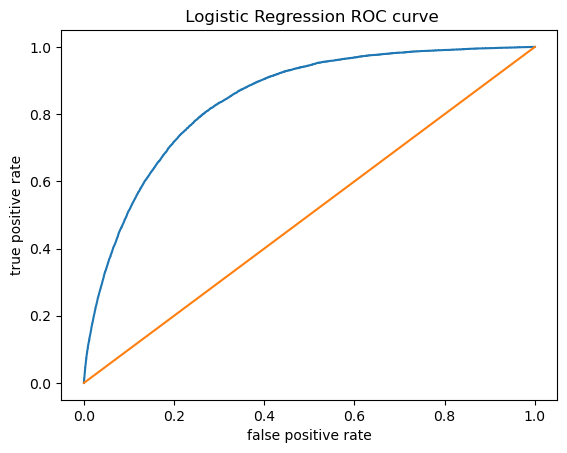

In [5]:
# create classification report
logi_report  = classification_report(y_test, y_pred_test_logi, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
logi_conf = confusion_matrix(y_test, y_pred_test_logi)
logi_conf = pd.DataFrame(logi_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== Logistic Regression Classification Report ==========')
print(logi_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== Logistic Regression AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_logi))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_logi)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Logistic Regression ROC curve')
plt.savefig(figpath + 'logi_roc_curve.png')
plt.show()

=========== Logistic Regression Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        79956                     6902
has_heart_disease                        6461                     5356



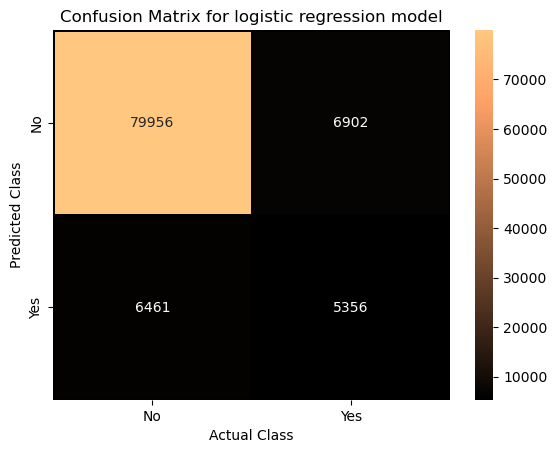

In [6]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_logi),
    annot = True,
    cmap = "copper",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for logistic regression model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.savefig(figpath + 'logit_cm.png')
print('=========== Logistic Regression Confusion Matrix ==========')
print(logi_conf)
print('==========================================================\n')

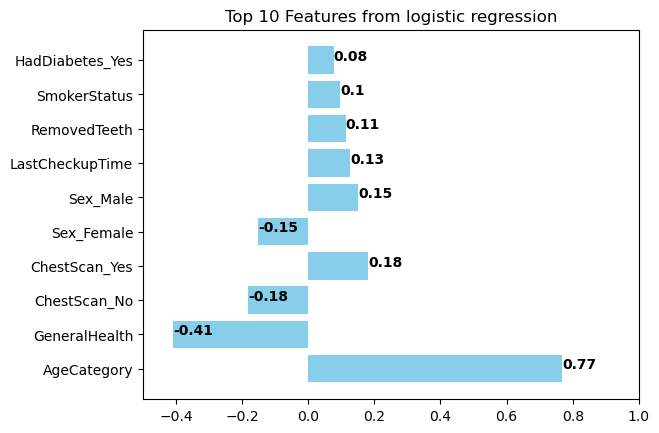

In [8]:
# Getting coefficients
# logi_final = pickle_jar['logi_final']
# log_final = log_final.best_estimator_.named_steps['clf']
logi_coef = log_final.coef_
avg_coef = np.mean(logi_coef, axis=0)

# create a dictionary for coefficients and column names
coef_dict = {}
for coef, col in zip(avg_coef, X_train.columns):
    coef_dict[col] = coef

# sort the dictionary by the absolute value of the coefficients
sorted_dict = dict(sorted(coef_dict.items(), 
                          key = lambda x: abs(x[1]), 
                          reverse = True))

# dataframe for the sorted dictionary with two columns
coef_df = pd.DataFrame(list(sorted_dict.items()), 
                       columns = ['Feature', 'Coefficient'])

coef_df['Feature'] = coef_df['Feature'].apply(lambda x: x.split('__')[1])

# select the top 10 coefficients
coef_df = coef_df.head(10)
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')

# add text annotation on the bar
for i, v in enumerate(coef_df['Coefficient']):
    plt.text(v, i, str(round(v, 2)),
             color='black', fontweight='bold',
             ha = 'left') 
plt.title('Top 10 Features from logistic regression')
# set x limit
plt.xlim(-0.5, 1)
plt.size = (8,6)
plt.savefig(figpath + 'logit_feature_importance.png')

### KNN model performance

=========== KNN Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.91      0.95      0.93     86858
Yes_HeartDisease       0.46      0.28      0.35     11817

        accuracy                           0.87     98675
       macro avg       0.68      0.62      0.64     98675
    weighted avg       0.85      0.87      0.86     98675

===================== KNN AUC score ===============
0.8180811071434415



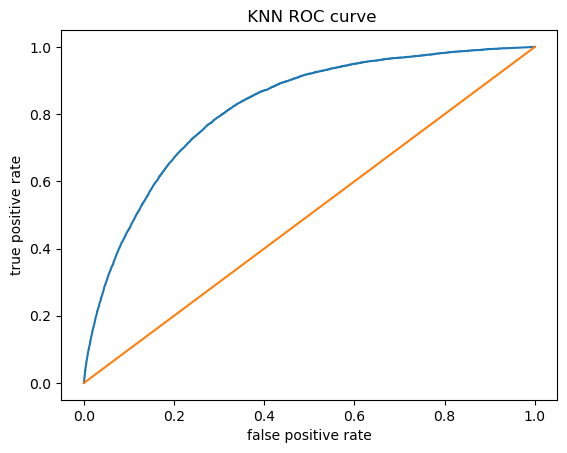

In [9]:
knn_report  = classification_report(y_test, y_pred_test_knn, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
knn_conf = confusion_matrix(y_test, y_pred_test_knn)
knn_conf = pd.DataFrame(knn_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== KNN Classification Report ==========')
print(knn_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== KNN AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_knn))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_knn)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' KNN ROC curve')
plt.savefig(figpath + 'knn_roc_curve.png')
plt.show()

=========== KNN Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        82947                     3911
has_heart_disease                        8458                     3359



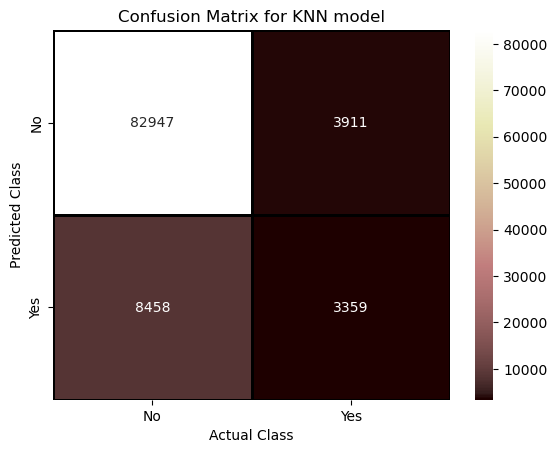

In [15]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_knn),
    annot = True,
    cmap = "pink",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )
plt.title('Confusion Matrix for KNN model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.savefig(figpath + 'knn_cm.png')

print('=========== KNN Confusion Matrix ==========')
print(knn_conf)
print('==========================================================\n')

### Random Forest Model Performance

In [10]:
y_pred_test_rf = test_predicted['rf_predicted']
y_pred_prob_rf = test_predicted['rf_predicted_prob']

=========== Random Forest Classification Report ==========
                  precision    recall  f1-score   support

 No_HeartDisease       0.92      0.92      0.92     86858
Yes_HeartDisease       0.44      0.44      0.44     11817

        accuracy                           0.86     98675
       macro avg       0.68      0.68      0.68     98675
    weighted avg       0.87      0.86      0.87     98675

===================== Random Forest AUC score ===============
0.8440934438073503



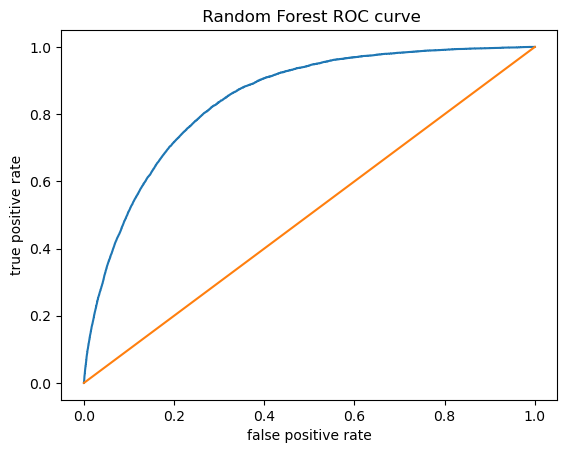

In [11]:
rf_report  = classification_report(y_test, y_pred_test_rf, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
rf_conf = confusion_matrix(y_test, y_pred_test_rf)
rf_conf = pd.DataFrame(rf_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== Random Forest Classification Report ==========')
print(rf_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== Random Forest AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_rf))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_rf)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' Random Forest ROC curve')
plt.savefig(figpath + 'rf_roc_curve.png')
plt.show()

=========== Random Forest Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        80100                     6758
has_heart_disease                        6592                     5225



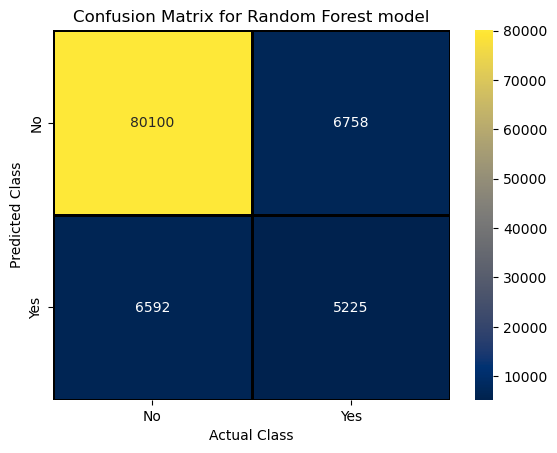

In [12]:
# confusion matrix for rf
sns.heatmap(confusion_matrix(y_test, y_pred_test_rf),
    annot = True,
    cmap = "cividis",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )

plt.title('Confusion Matrix for Random Forest model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.savefig(figpath + 'rf_cm.png')
print('=========== Random Forest Confusion Matrix ==========')
print(rf_conf)
print('==========================================================\n')

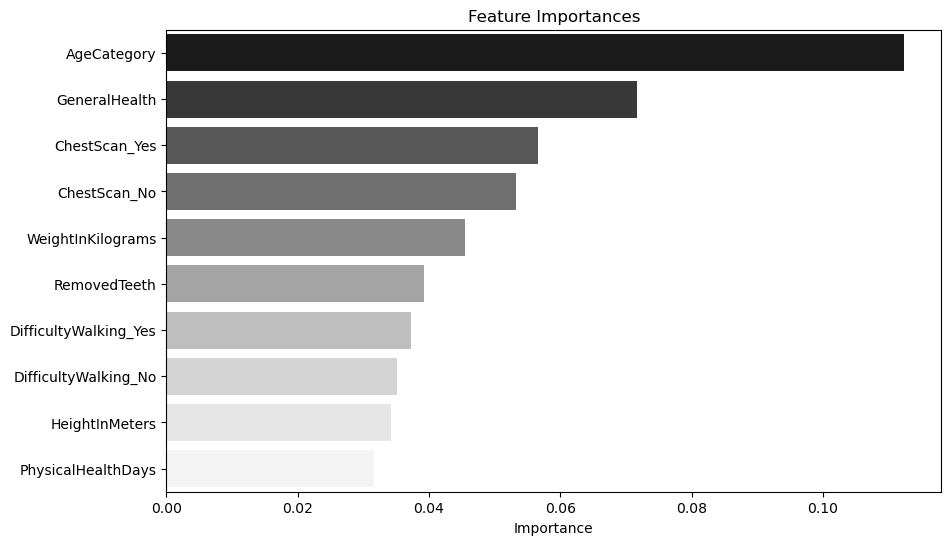

In [14]:
# Feature importance
# rf_model = pickle.load(open(indir + 'rf_model_select.pkl', 'rb'))
# rf_model = rf_model.best_estimator_
feature_importances = rf_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
# change the feature names to the original names
feature_importances_df['Feature'] = feature_importances_df['Feature'].apply(lambda x: x.split('__')[1])
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', palette = 'Greys_r',
            data=feature_importances_df.head(10))
plt.title('Feature Importances')
# remove y label
plt.ylabel('')
plt.savefig(os.path.join(figpath, "rf_feature_importance.png"))
plt.show()

In [22]:
# RF Decision Tree
tree_index = 0  
decision_tree = rf_model.estimators_[tree_index]

dot_file_path = os.path.join(figpath, f"decision_tree_{tree_index}.dot")

export_graphviz(decision_tree, out_file=dot_file_path, 
                feature_names=X_train.columns,
                filled=True, rounded=True, special_characters=True)

graph = graph_from_dot_file(dot_file_path)

graph.write_png(os.path.join(figpath, f"decision_tree_{tree_index}.png"))

NameError: name 'graph_from_dot_file' is not defined

### XGBoost Model Performance

In [20]:
y_pred_test_xgb = test_predicted['xgb_predicted']
y_pred_prob_xgb = test_predicted['xgb_predicted_prob']

In [15]:
# create classification report
xgb_report  = classification_report(y_test, y_pred_test_xgb, 
                                     target_names = ['No_HeartDisease', 
                                                     'Yes_HeartDisease'])
# create confusion matrix
xgb_conf = confusion_matrix(y_test, y_pred_test_xgb)
xgb_conf = pd.DataFrame(xgb_conf, 
                         columns = ['predicted_no_heart_disease', 
                                    'predicted_heart_disease'],
                         index = ['no_heart_disease',
                                  'has_heart_disease'])

print('=========== XGB Classification Report ==========')
print(xgb_report)
# plotting the ROC curve and printing the AUC score for the logistic model
print('===================== XGB AUC score ===============')
print(metrics.roc_auc_score(y_test,y_pred_prob_xgb))
print('===================================================================\n')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_xgb)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' XGB ROC curve')
plt.savefig(figpath + 'xgb_roc_curve.png')
plt.show()

NameError: name 'y_pred_test_xgb' is not defined

=========== XGB Confusion Matrix ==========
                   predicted_no_heart_disease  predicted_heart_disease
no_heart_disease                        79011                     7847
has_heart_disease                        6071                     5746



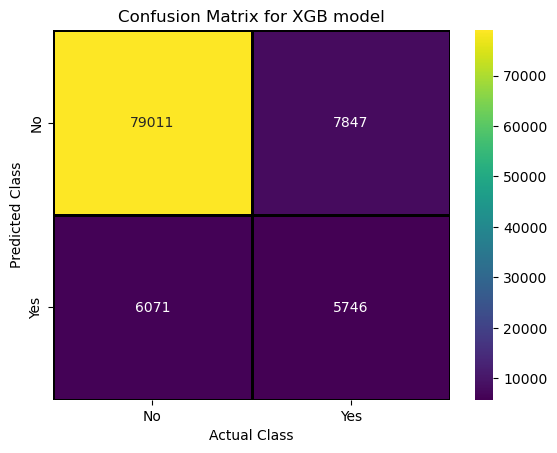

In [ ]:
# confusion matrix for xgb
sns.heatmap(confusion_matrix(y_test, y_pred_test_xgb),
    annot = True,
    cmap = "viridis",
    linewidths = 2,
    linecolor = "black",
    xticklabels = ['No','Yes'],
    yticklabels = ['No','Yes'],
    fmt = '.0F'
           )

plt.title('Confusion Matrix for XGB model')
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.savefig(figpath + 'xgb_cm.png')
print('=========== XGB Confusion Matrix ==========')
print(xgb_conf)
print('==========================================================\n')


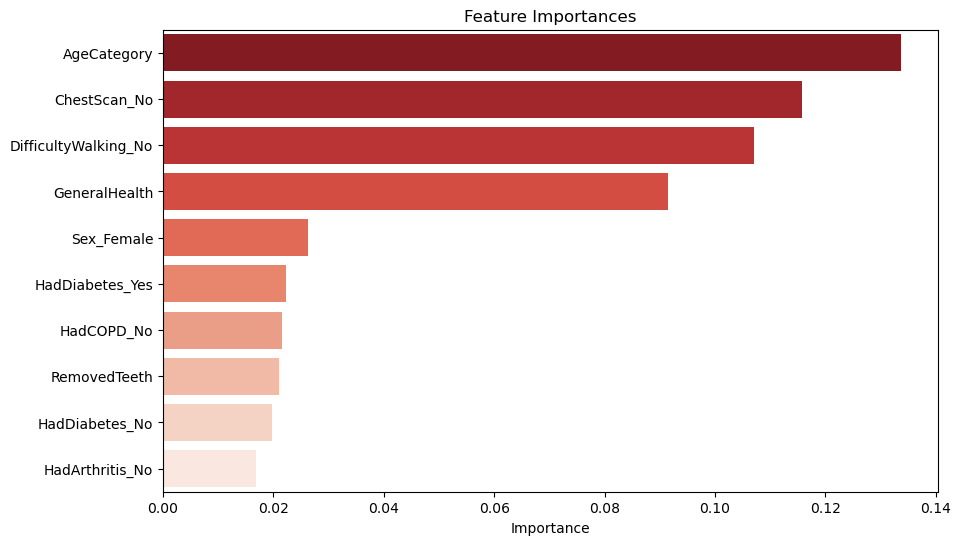

<Figure size 640x480 with 0 Axes>

In [16]:
# Feature importance
# xgb_model = pickle.load(open(indir + 'xgboost_model_select.pkl', 'rb'))
# xgb_model = xgb_model.best_estimator_
feature_importances = xgb_model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
# change the feature names to the original names
feature_importances_df['Feature'] = feature_importances_df['Feature'].apply(lambda x: x.split('__')[1])
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',palette = "Reds_r",
            data=feature_importances_df.head(10))
plt.title('Feature Importances')
plt.ylabel('')
plt.show()
plt.savefig(os.path.join(figpath, "xgb_feature_importance.png"))


ImportError: You must install graphviz to plot tree

<Figure size 2000x2000 with 0 Axes>

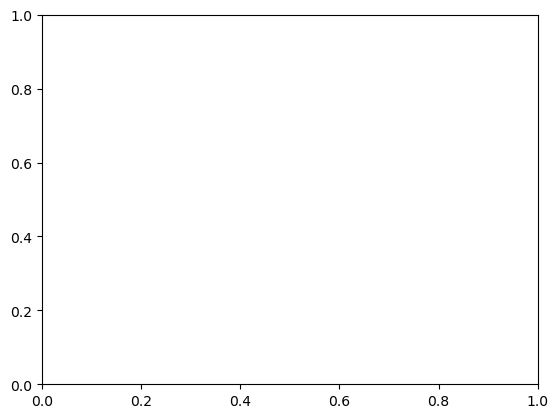

In [47]:
# XG Decision Tree
xgb_model
plt.figure(figsize=(20, 20))
xgb.plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.savefig(os.path.join(figpath, "xgb_tree.png"))
plt.show()

### **Final Metrics**

NameError: name 'y_pred_prob_xgb' is not defined

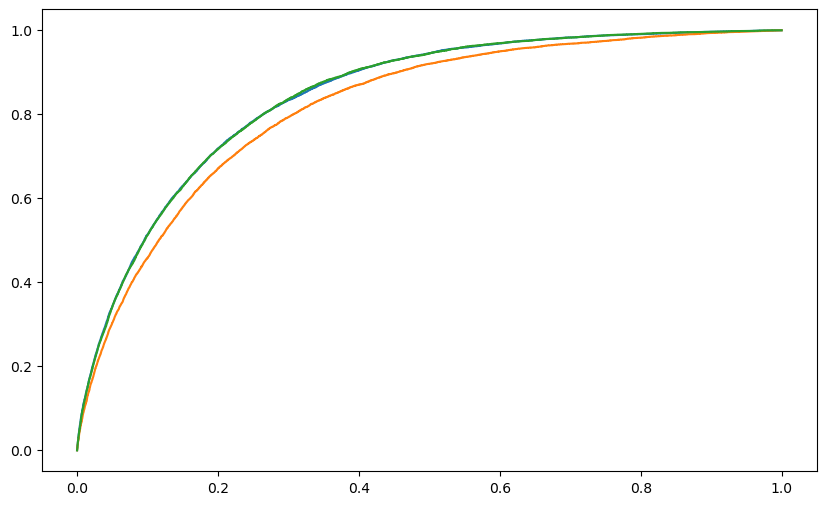

In [17]:
# plot all auc curves in one plot
plt.figure(figsize=(10, 6))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_logi)
plt.plot(fpr, tpr, label = 'Logistic Regression')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_knn)
plt.plot(fpr, tpr, label = 'KNN')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_rf)
plt.plot(fpr, tpr, label = 'Random Forest')
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob_xgb)
plt.plot(fpr, tpr, label = 'XGBoost')
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title(' ROC curve for all models')
plt.legend()
plt.savefig(figpath + 'all_model_roc.png')

In [18]:
# Accuracy
logi_accuracy = accuracy_score(y_test, y_pred_test_logi)
knn_accuracy = accuracy_score(y_test, y_pred_test_knn)
rf_accuracy = accuracy_score(y_test, y_pred_test_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_test_xgb)

# Precision
logi_precision = precision_score(y_test, y_pred_test_logi)
knn_precision = precision_score(y_test, y_pred_test_knn)
rf_precision = precision_score(y_test, y_pred_test_rf)
xgb_precision = precision_score(y_test, y_pred_test_xgb)

# Recall
logi_recall = recall_score(y_test, y_pred_test_logi)
knn_recall = recall_score(y_test, y_pred_test_knn)
rf_recall = recall_score(y_test, y_pred_test_rf)
xgb_recall = recall_score(y_test, y_pred_test_xgb)

# F1 Score
logi_f1 = f1_score(y_test, y_pred_test_logi)
knn_f1 = f1_score(y_test, y_pred_test_knn)
rf_f1 = f1_score(y_test, y_pred_test_rf)
xgb_f1 = f1_score(y_test, y_pred_test_xgb)

# AUC
logi_auc = roc_auc_score(y_test, y_pred_prob_logi)
knn_auc = roc_auc_score(y_test, y_pred_prob_knn)
rf_auc = roc_auc_score(y_test, y_pred_prob_rf)
xgb_auc = roc_auc_score(y_test, y_pred_prob_xgb)

# Sensitivity 
logi_sensitivity = logi_conf.iloc[1,1]/(logi_conf.iloc[1,1] + logi_conf.iloc[1,0])
knn_sensitivity = knn_conf.iloc[1,1]/(knn_conf.iloc[1,1] + knn_conf.iloc[1,0])
rf_sensitivity = rf_conf.iloc[1,1]/(rf_conf.iloc[1,1] + rf_conf.iloc[1,0])
xgb_sensitivity = xgb_conf.iloc[1,1]/(xgb_conf.iloc[1,1] + xgb_conf.iloc[1,0])

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'XGB'],
    'Accuracy': [logi_accuracy, knn_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [logi_precision, knn_precision, rf_precision, xgb_precision],
    'Sensitivity/Recall': [logi_recall, knn_recall, rf_recall, xgb_recall],
    'F1 Score': [logi_f1, knn_f1, rf_f1, xgb_f1],
    'AUC': [logi_auc, knn_auc, rf_auc, xgb_auc],
})

metrics_df

NameError: name 'y_pred_test_xgb' is not defined

In [25]:
# save metrics to parquet
metrics_df.to_parquet(os.path.join(path_google, "metrics.parquet"))

In [20]:
# color the table
def highlight_max(df):
    max_value = df == df.max()
    return ['background-color: pink' if v else '' for v in max_value]

metrics_df.style.apply(highlight_max, subset=['Accuracy', 'Precision', 
                                              'Sensitivity/Recall', 
                                              'F1 Score', 'AUC'])

,Model,Accuracy,Precision,Sensitivity/Recall,F1 Score,AUC
0,Logistic Regression,0.864576,0.436939,0.453245,0.444943,0.843969
1,KNN,0.874649,0.462036,0.284252,0.351967,0.818081
2,Random Forest,0.864707,0.436034,0.442160,0.439076,0.844093
3,XGB,0.858951,0.422718,0.486249,0.452263,0.846133
